# Import Packages

In [1]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# autoreload 
%load_ext autoreload
%autoreload 2

In [ ]:
# Correct path: add the directory that contains `level_2`
CUSTOM_UTILS_PATH = Path(os.getcwd()).parent / 'src' / 'compass'
sys.path.append(str(CUSTOM_UTILS_PATH))

try:
    import level_1
    from level_1 import *
    print("Utils loaded successfully!")
except ImportError as e:
    print(f"Warning: Could not import custom modules: {e}")

Utils loaded successfully!


In [3]:
import init_config
from init_config import *

import notebook_utils
from notebook_utils import * 

Location of Computer 1 Videos: 
Location of Computer 2 Videos: 
Central Video Location: d:\Gladstone Dropbox\Palop Lab\Shreya\Code\TEST_COMPASS\videos\original_videos
DLC Scorer: DLC_resnet50_LabyrinthMar13shuffle1_1000000
Tracking bodyparts: nose, belly, sternum, leftflank, rightflank, tailbase
Experimental groups: ['A', 'B', 'C', 'D']


In [4]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42

# Import Mouse Metadata

In [5]:
# Read in mouse metadata file
mouseinfo = pd.read_excel(os.path.join(METADATA_PATH,METADATA_FILE), sheet_name=TRIAL_TYPE)
print('Metadata columns: ',mouseinfo.columns)

# Consider only non-NA Sessions
mouseinfo = mouseinfo[~mouseinfo['Session #'].isna()]

# Find the subset of trials need to be excluded
mouseinfo = mouseinfo.loc[mouseinfo['Exclude Trial']!= 'yes'].reset_index(drop=True)

Metadata columns:  Index(['Session #', 'Run Date', 'Time Of Day', 'Rack Location', 'Computer',
       'Noldus Chamber', 'Camera #', 'Noldus Trial', 'Noldus Project Name',
       'DSI Trial', 'ID', 'Name', 'Sex', 'Status', 'Line', 'Genotype',
       'GenotypeOG', 'Birth Date', 'Age (months)', 'Housing ID',
       'Transmitter #', 'Exclude Trial', 'X1', 'X2', 'Y1', 'Y2', 'NOTES'],
      dtype='object')


# Import Preprocessed CSV file

In [6]:
preproc_df = pd.read_csv(os.path.join(BASE_PATH,'csvs','combined','Preprocessed_combined_file_exclusions.csv'))

preproc_df['ID']=preproc_df['Session'].astype('category')

# Sort data by ID, Session, and S_no, and remove rows with missing values
preproc_df = (
    preproc_df
    .sort_values(by=["ID", "Session", "S_no"])
    .dropna()
    .reset_index(drop=True)
)

# Calculate Step Length and Turn Angle

In [8]:
# Run prep
final_df = prep_data(
    data=preproc_df,
    type="UTM",                         # or "LL" if lon/lat in coordNames
    coordNames=("x", "y"),
    covNames=[],  # example covariates if present
    centers=None,                       # e.g., np.array([[0,0], [10,10]])
    centroids=None,                     # e.g., {"goal": goal_df_with_time}
    angleCovs=None,
    altCoordNames=None
)

# Inspect
final_df.head()

final_df = (
    final_df
    .dropna()
    .reset_index(drop=True)
)

C:\Users\PalopLabPortal\AppData\Local\Temp\ipykernel_26512\597228845.py:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _id, g in df.groupby("ID", sort=False):


# Step and Angle Distribution

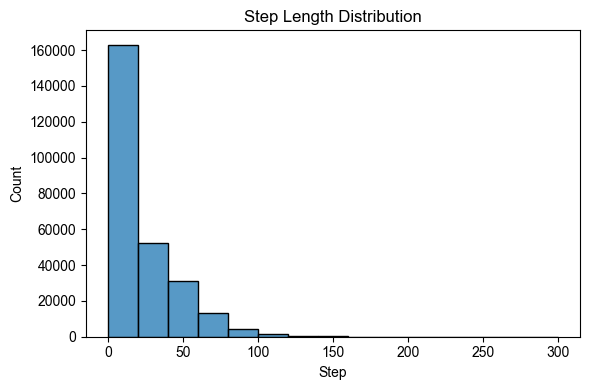

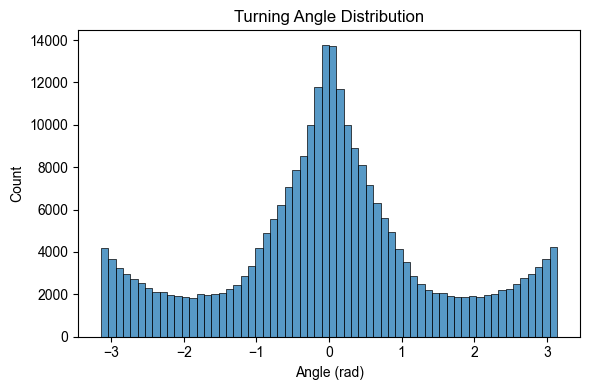


Summary: Step
count    265490.000000
mean         21.121542
std          23.254561
min           0.000281
25%           3.304319
50%          12.055826
75%          32.961413
max         285.400817
Name: step, dtype: float64

Summary: Angle (radians)
count    265490.000000
mean          0.001154
std           1.465752
min          -3.141549
25%          -0.723278
50%           0.002277
75%           0.723531
max           3.141575
Name: angle, dtype: float64


In [ ]:
# Histogram: Step Length Distribution
plt.figure(figsize=(6, 4))
sns.histplot(final_df["step"], bins=range(0, int(final_df["step"].max()) + 20, 20), kde=False)
plt.title("Step Length Distribution")
plt.xlabel("Step")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Histogram: Turning Angle Distribution (in radians)
plt.figure(figsize=(6, 4))
sns.histplot(final_df["angle"], bins=int((final_df["angle"].max() - final_df["angle"].min()) / 0.1), kde=False)
plt.title("Turning Angle Distribution")
plt.xlabel("Angle (rad)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


print("\nSummary: Step")
print(final_df["step"].describe())

print("\nSummary: Angle (radians)")
print(final_df["angle"].describe())


# Run CoMPASS Level-1

Goal                               	R (momentuHMM)	                                  Python (SciPy analogue)
___________________________________________________________________________________________________________________________
Gradient-based optimization	      "BFGS", "L-BFGS-B"	                                 "BFGS", "L-BFGS-B"
Derivative-free (simplex)	         "Nelder-Mead"                                      	"Nelder-Mead"
Derivative-free (Newton-like)	         "nlm"                                              	"Powell

In [ ]:
# final_df must have: 'Session', 'step' (>0), 'angle' (radians)
res = fit_best_hmm(
    preproc_df=final_df,
    n_states=2,
    n_iter=5,
    opt_methods=("BFGS","L-BFGS-B","Nelder-Mead","Powell"),
    use_abs_angle=(True, False),          # True => |angle|~Gamma ; False => angle~VM
    stationary_flag="auto",
    use_data_driven_ranges=True,
    angle_mean_biased=(np.pi/2, 0.0),     # used for VM branch
    session_col="Session",
    seed=123,
    show_progress=True
)


# State 1 = low step + high turn angle
# State 2 = high step + low turn angle

In [ ]:
print_hmm_summary(res.summary, res.model)
res.records.head()       # search log
res.data.head()          # original df + HMM_State + posteriors


 Best Model Characteristics:
• Angle type: |angle| ~ Gamma
• Optimizer: BFGS
• AIC: 2529152.02 | logLik: -1264565.01
• Start probs: [1.0, 0.0]
• Transmat:
 [[0.8788 0.1212]
 [0.1034 0.8966]]
• Step Means: [4.5073, 35.2993]
• |angle| Gamma k: [1.582, 0.867]
• |angle| Gamma theta: [0.991, 0.793]
• Final state ordering: State 1 = low step + high turn; State 2 = high step + low turn



,ID,step,angle,x,y,Grid Number,likelihood,S_no,Region,Session,Genotype,Sex,NodeType,Velocity,Bout_ID,HMM_State,Post_Prob_1,Post_Prob_2
0,3,3.912921,-1.149582,267.526978,873.733704,47,0.986050,750,Entry Zone,3,WT-WT,Female,Entry Nodes,19.564603,0,1.0,0.000008,4.933138e-20
1,3,1.981172,0.620240,265.571991,873.412659,47,0.953975,751,Entry Zone,3,WT-WT,Female,Entry Nodes,9.905860,0,1.0,0.000008,3.718385e-09
2,3,1.066163,-2.518697,266.325684,874.166748,47,0.958631,752,Entry Zone,3,WT-WT,Female,Entry Nodes,5.330815,0,1.0,0.000008,3.487879e-10
3,3,0.899351,2.238799,265.432495,874.271851,47,0.932229,753,Entry Zone,3,WT-WT,Female,Entry Nodes,4.496755,0,1.0,0.000008,3.109230e-10
4,3,0.519677,1.625876,265.400269,873.753174,47,0.909978,754,Entry Zone,3,WT-WT,Female,Entry Nodes,2.598385,0,1.0,0.000008,2.175297e-10


In [21]:
res.data.HMM_State.value_counts()

HMM_State
2.0    142845
1.0    122645
Name: count, dtype: int64

# Export CSV with HMM State appended

In [ ]:
res.data.to_csv(os.path.join(BASE_PATH,'csvs','combined','HMM_2State_file.csv'),index=0)
